# Simple image foreground co-segmentation using DINOv2 features via Hugging Face

How can we identify the foreground regions in a collection of images of some shared category such as *cake*?

Let's see how to hone in on the relevant regions in each image in just a few lines of code, without requiring any labelled data! We will use a simplified version of the algorithm from ["Deep ViT Features as Dense Visual Descriptors" (Amir et al. 2022)](https://dino-vit-features.github.io/).

First, load the images:

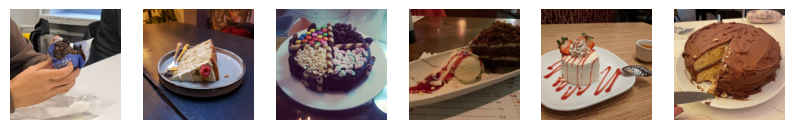

In [1]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt

filenames = glob('images/*.png')
imgs = [Image.open(fn).convert('RGB') for fn in filenames]

fig, axs = plt.subplots(1, len(imgs), figsize=(10, 4))
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.axis('off')

Now, let's calculate [DINOv2](https://huggingface.co/docs/transformers/model_doc/dinov2) features for these images. DINOv2 calculates powerful self-supervised representations for images that can be used to get SOTA results for many computer vision tasks. Load the DINOv2 model with the Hugging Face API:

In [ ]:
from transformers import AutoImageProcessor, AutoModel

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

Following Amir et al., we use the keys from the last self-attention layer as powerful embeddings for image patches (though you could also try the even simpler approach of just using `outputs.last_hidden_state` rather than these keys, YMMV). While the HF API does not natively return these embeddings, we can use a simple [Pytorch hook](https://medium.com/the-dl/how-to-use-pytorch-hooks-5041d777f904) to collect them in our `KeysExtractor` object as the model executes:

In [3]:
class KeysExtractor:
    
    def __init__(self, model, n_layer=-1):
        self.keys = None
        key_module = model.encoder.layer[n_layer].attention.attention.key
        key_module.register_forward_hook(self.save_keys)
    
    def save_keys(self, layer, inputs, keys):
        self.keys = keys

ke = KeysExtractor(model)

Now let's embed our images. We pass `output_attentions=True` because we will also need the model's self-attention maps for later:

In [4]:
import torch

inputs = processor(images=imgs, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

We can now use our extracted keys to segment our images in a completely unsupervised fashion via k-means clustering. For simplicity we use three clusters here, but the ideal number of clusters depends on the image collections and could be estimated with a method such as the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

In [6]:
from sklearn.cluster import KMeans

n_clusters = 3

K = ke.keys[:, 1:, :].reshape(len(imgs) * 256, -1)
# ^ shape: (n_images * 256, n_hidden)
labels = KMeans(n_clusters=n_clusters).fit_predict(K).reshape(len(imgs), 16, 16)
# ^ contains cluster indices; shape: (n_images, 16, 16)

Visualizing these clusters, we see that they roughly correspond to cake, plates, and background:

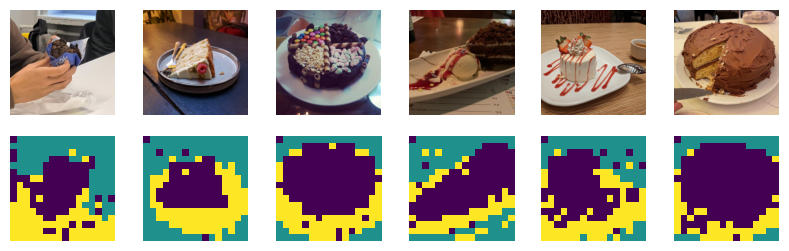

In [7]:
fig, axs = plt.subplots(2, len(imgs), figsize=(10, 3))
for i, (img, img_labels) in enumerate(zip(imgs, labels)):
    axs[0][i].imshow(img)
    axs[1][i].imshow(img_labels)
for row in axs:
    for ax in row:
        ax.axis('off')

We could pick the foreground cluster(s) manually, but this can also be estimated automatically. Amir et al. suggest scoring clusters using the model's self-attention values between each patch in the cluster and the \[CLS\] visual token. A similar calculation is shown below:

In [8]:
import numpy as np

A = outputs.attentions[-1]
S = A[:, :, 1:, 0].mean(dim=1).reshape(-1, 16, 16)
S -= S.min(dim=1, keepdim=True).values.min(dim=2, keepdim=True).values
S /= S.max(dim=1, keepdim=True).values.max(dim=2, keepdim=True).values
mean_saliencies = np.array([S[labels == k].mean() for k in range(n_clusters)])

foreground_cluster = mean_saliencies.argmax().item()

print('Cluster saliency values:', *mean_saliencies)
print('Most salient (foreground) cluster:', foreground_cluster)

Cluster saliency values: 0.46040693 0.1746955 0.18035078
Most salient (foreground) cluster: 0


For simplicity we only consider the most salient cluster as foreground, though this can be extended to selecting multiple clusters. Finally, we can use this selection to produce rough binary masks that co-segment the foreground in the images:

In [9]:
masks = [
    Image.fromarray(labels == foreground_cluster).resize(img.size)
    for labels, img in zip(labels, imgs)
]

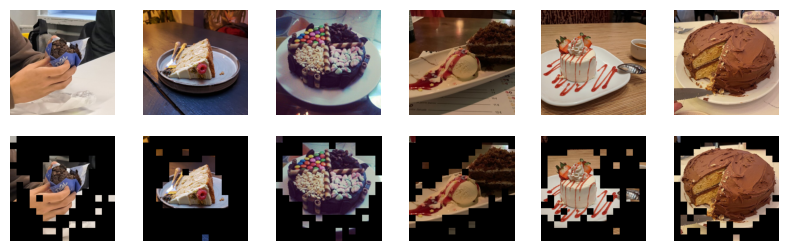

In [10]:
fig, axs = plt.subplots(2, len(imgs), figsize=(10, 3))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img_ = np.asarray(img) * np.asarray(mask)[..., None]
    axs[0][i].imshow(img)
    axs[1][i].imshow(img_)
for row in axs:
    for ax in row:
        ax.axis('off')

And there you have it!

To get more precise results, you could refine these rough masks using a classic algorithm like [GrabCut](https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html) or by using them to construct prompts for the model [Segment Anything](https://huggingface.co/docs/transformers/model_doc/sam).